# Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

     
class Trainer:
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
        
    
    def train(self, train_data, draw_curve=True):
        self.encoder = train_data.encoder
        
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        train_loss_list, train_acc_list = [], []
        
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_data)
                hidden = self.model.init_hidden(y_batch.shape[0])
                y_pred, _ = self.model(X_batch, hidden)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                num_acc = torch.sum(torch.argmax(y_batch, axis=-1) == torch.argmax(y_pred, axis=-1))
                batch_acc = num_acc / (y_pred.shape[0] * y_pred.shape[1])
                
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].set_title("Accuracy")
            axes[1].legend()
    
    def sample(self, num_seq=10):
        self.model.eval()
        seqs = []
        with torch.no_grad():
            for _ in tqdm(range(num_seq), leave=False):
                chars = ['SOS']
                hidden = self.model.init_hidden(1)
                while chars[-1] != 'EOS':
                    input_encoding = self.encoder.transform(np.array([chars[-1]]).reshape(-1, 1)).toarray()
                    input_encoding = torch.tensor(input_encoding, dtype=torch.float).reshape(1, 1, -1)
                    out, hidden = self.model(input_encoding, hidden)

                    prob = out.detach().numpy().flatten()
                    prob /= np.sum(prob)

                    index = np.random.choice(self.model.input_size, p=prob)
                    out_encoding = np.zeros((1, self.model.input_size))
                    out_encoding[0, index] = 1.0
                    char = data.encoder.inverse_transform(out_encoding).flatten().tolist()[0]
                    chars.append(char)
                seqs.append(''.join(chars[1:-1]))
        return seqs


def validate(seq):
    """
    Report the number of unique and valid SMILES strings
    
    Parameters
    ----------
    seq: list of str
        List of strings to validate
    
    Returns
    -------
    valid: list of str
        List of valid and unique SMILES strings
    """
    num = len(seq)
    unique = set(seq)
    valid = []
    for s in unique:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            valid.append(s)
            
    print(f"Number of unique SMILES: {len(unique)}")
    print(f"Number of valid & unique SMILES: {len(valid)}")
    return valid

## (a)

*For debugging*: Length of the vocabulary (i.e. unique characters) should be 17.

In [2]:
def load_smiles(path):
    with open(path) as f:
        smiles = f.read().split('\n')
    return smiles


def pad_start_end_token(smiles):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for smi in smiles:
        padded.append(['SOS'] + list(smi) + ['EOS'])
    return padded


smiles = load_smiles('/Users/mac_1/Desktop/CHEM C142/ani_smiles_clean.txt')
padded_smiles = pad_start_end_token(smiles)

vocab = set(char for smi in padded_smiles for char in smi)

*For debugging*: Please execute the following block to test the vocabulary and padded smiles

In [3]:
def test_pad():
    assert padded_smiles[0] == ['SOS', 'C', 'EOS']
    assert padded_smiles[1] == ['SOS', 'N', 'EOS']
    assert len(vocab) == 17
    print("Well done!")

test_pad()

Well done!


Finish the missing lines to do the one-hot encoding.

In [4]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, vocab):
        self.vocab = np.array(list(vocab), dtype=str).reshape(-1, 1)  # Ensure vocab is a list and then convert to numpy array
        
        self.encoder = OneHotEncoder()
        self.encoder.fit(self.vocab)  # Fit the encoder with the reshaped vocabulary array
        
        # Create one-hot encoded tensors for each SMILES string
        self.data = [
            torch.tensor(
                self.encoder.transform(np.array(list(s)).reshape(-1, 1)).toarray(),
                dtype=torch.float
            ) for s in smiles
        ]
        
        # Pad the sequences to have the same length
        self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        
        # Split the data into inputs and targets
        self.X = self.data[:, :-1, :]
        self.y = self.data[:, 1:, :]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

data = SmilesDataset(padded_smiles, vocab)
input_size = data.vocab.shape[0]  # The number of unique characters in the vocabulary
input_size

17

## (b)

In [5]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, h):
        out, h = self.rnn(x, h) # Rnn
        out = self.fc(out) # output fc
        out = self.softmax(out) # softmax
        return out, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Number of unique SMILES: 13
Number of valid & unique SMILES: 9


['C=CC=CC=O',
 'C=CCC=O',
 'C=CC=CSOSC=O',
 'C=CC=C=O',
 'C=CC=C',
 'C=CC=CN',
 'C=CC=CNC',
 'C=CC=O',
 'C=CC=CNO']

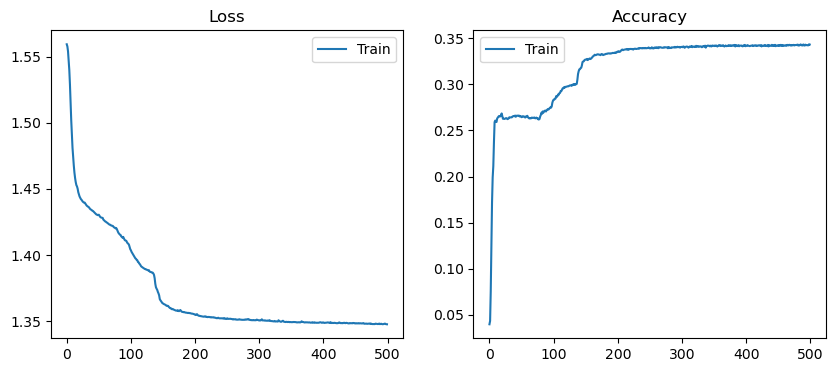

In [6]:
model = VanillaRNN(input_size, hidden_size=32, num_layers=1)
trainer = Trainer(model, opt_method="adam", learning_rate=1e-3, batch_size=128, epoch=500, l2=1e-5)
trainer.train(data)
seqs = trainer.sample(num_seq=1000) # generate 1000 strings
validate(seqs)

## (c)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(out)
        out = self.softmax(out)
        return out, h
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

Number of unique SMILES: 22
Number of valid & unique SMILES: 17


['C=C=CCCN',
 'C=CCOC',
 'C=CC1CC1O',
 'C=CC1CC1C',
 'C=CCCOC',
 'CC1CC1O',
 'C=C1CCC1',
 'CC1CC1N',
 'CC1CC1CO',
 'C=C=CCCO',
 'CCC1CC1',
 'CC1CC1',
 'CC1CC1C',
 'C=CC1CC1N',
 'CC1CC1CC',
 'C=CC1CC1',
 'C=CC1CC1SOS']

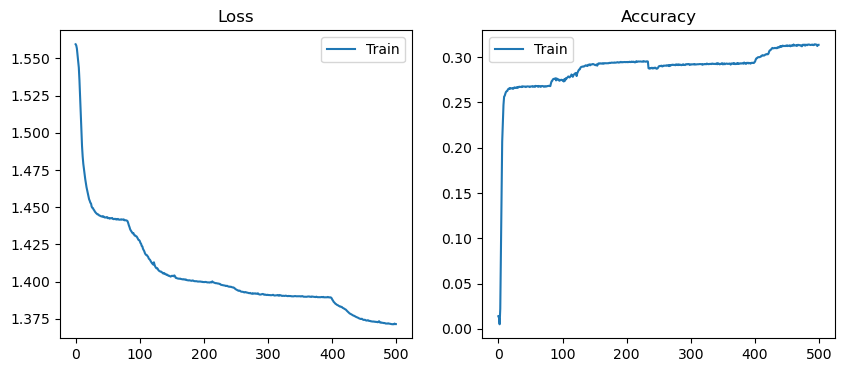

In [8]:
model = LSTM(input_size=input_size, hidden_size=32, num_layers=1)
trainer = Trainer(model=model, opt_method="adam", learning_rate=1e-3, batch_size=128, epoch=500, l2=1e-5)
trainer.train(data)
seqs = trainer.sample(num_seq = 1000) # generate 1000 strings
validate(seqs)